<a href="https://colab.research.google.com/github/lawgorithm/timeseries/blob/main/ARIMA/SARIMA_and_Holt_Winters_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMA and Holt-Winters Examples

In [1]:
!pip install pmdarima

In [2]:
# @title Imports
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.arima import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
# @title Load the Souvenir Sales data from GitHub
data_url = 'https://raw.githubusercontent.com/lawgorithm/timeseries/main/data/SouvenirSales.csv'
suv = pd.read_csv(data_url)
print(suv.head())

     Date    Sales
0  Jan-95  1664.81
1  Feb-95  2397.53
2  Mar-95  2840.71
3  Apr-95  3547.29
4  May-95  3752.96


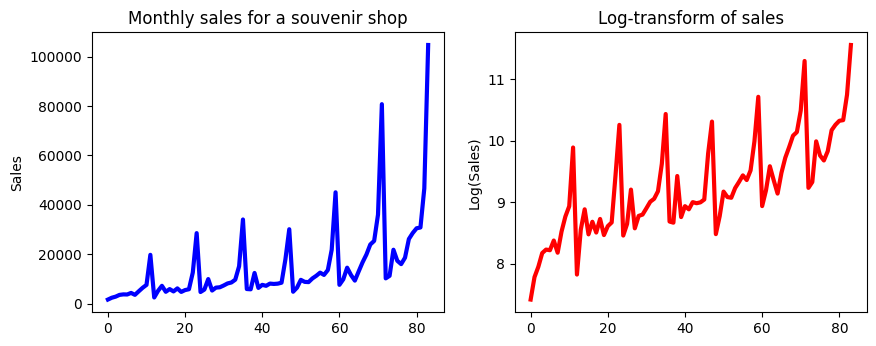

In [4]:
# First, we will plot the time series
plt.figure(figsize=(10, 8))  # Adjust figure size as needed

# This time series is clearly not stationary. There is an
# increasing trend and increasing variance over time and there
# appears to be some seasonality
plt.subplot(2, 2, 1)  # Create a subplot for the time series
plt.plot(suv['Sales'], color='blue', linewidth=3)
plt.title('Monthly sales for a souvenir shop')
plt.ylabel('Sales')

# We try a log transformation, which seems to handle
# the problem of increasing variance over time. However,
# a trend upwards still remains
plt.subplot(2, 2, 2)

plt.plot(np.log(suv['Sales']), color='red', linewidth=3)
plt.title('Log-transform of sales')
plt.ylabel('Log(Sales)')

plt.show()


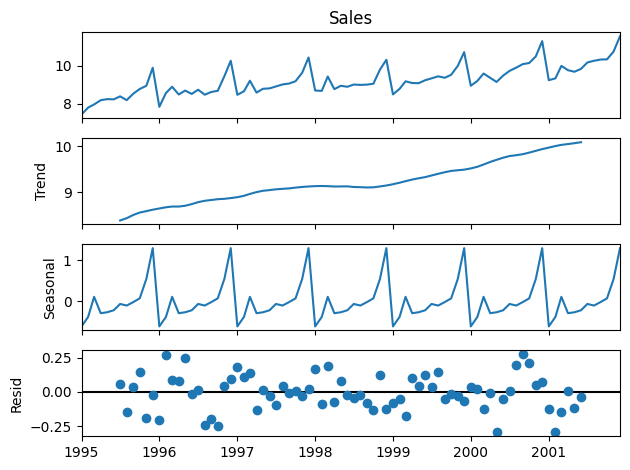

In [5]:
# The decompose function is a nice function that non-parametrically
# visually decomposes your time series into trend, seasonal and random
# components. See https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/decompose
# to understand the methodology, which is pretty simple

# Reformat the date column
suv['Date'] = pd.to_datetime(suv['Date'], format='%b-%y')

# Set 'Date' as index
suv.set_index('Date', inplace=True)

# Extract time series
data_ts = suv['Sales']

# Perform seasonal decomposition with specified period
decomposition = seasonal_decompose(np.log(data_ts), model='additive', period=12)

# Plot the decomposition components
decomposition.plot()
plt.show()

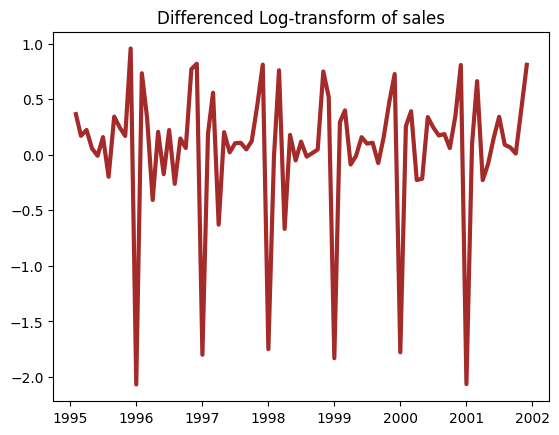

In [6]:
# We try differencing to get rid of the trend
# The trend is gone, but we still have some seasonal
# spikes

# Log transformation
log_sales = np.log(data_ts)

# Differencing
diff_log_sales = log_sales.diff()

# Plotting
plt.plot(diff_log_sales, color='brown', linewidth=3)
plt.title('Differenced Log-transform of sales')
plt.ylabel('')
plt.show()


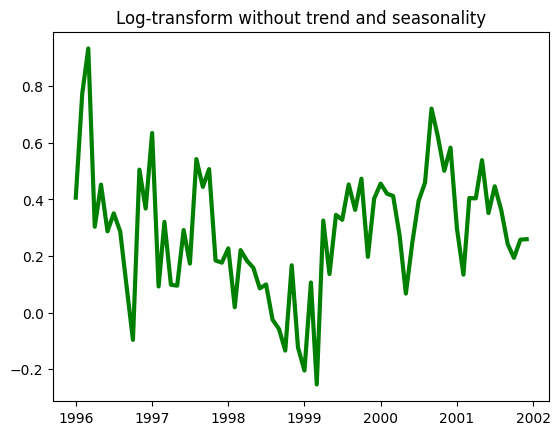

In [7]:
# We could have differenced out the 12 month seasonality first
# on the log scale. But there still seems to be a trend, first going
# down over time then going back up

# Seasonal differencing
diff_log_sales_seasonal = log_sales.diff(periods=12)

# Plotting
plt.plot(diff_log_sales_seasonal, color='green', linewidth=3)
plt.title('Log-transform without trend and seasonality')
plt.ylabel('')
plt.show()



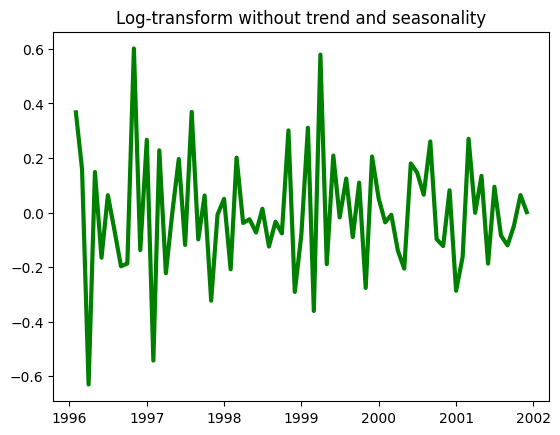

In [8]:
# 12 month seasonal and "normal" differencing of the log data yields something
# that looks more stationary. Maybe the variance at the beginning
# looks different from the variance at the end, but we will just ignore that

# First-order differencing
double_diff = diff_log_sales_seasonal.diff()

# Plotting
plt.plot(double_diff, color='green', linewidth=3)
plt.title('Log-transform without trend and seasonality')
plt.ylabel('')
plt.show()

In [9]:
# Note that differencing in python will remove some value from the time series
# and replace them with nan. I.e. 1st order differencing will replace one value
# with nan. Differencing with a frequency of 12 (annual seasonality) will remove
# 12 values, etc

# for i, val in enumerate(diff_log_sales):
# for i, val in enumerate(diff_log_sales_seasonal):
for i, val in enumerate(double_diff):
  if math.isnan(val):
    print(f'index, val: {i}, {val}')
  else:
    print(f'index, val: {i}, {val}')
    break

truncated_diff_log_sales = diff_log_sales[1:],
truncated_diff_log_sales_seasonal = diff_log_sales_seasonal[12:],
truncated_double_diff = double_diff[13:]

index, val: 0, nan
index, val: 1, nan
index, val: 2, nan
index, val: 3, nan
index, val: 4, nan
index, val: 5, nan
index, val: 6, nan
index, val: 7, nan
index, val: 8, nan
index, val: 9, nan
index, val: 10, nan
index, val: 11, nan
index, val: 12, nan
index, val: 13, 0.36737733984708054


In [10]:
# ndiffs() is a function that automatically finds the amount of
# of differencing (the integrated term) based on a choice of statistical test
# for stationarity

test = 'adf'  # or use ['kpss', 'adf', 'pp']
alpha = 0.05  # significance level

ts_arrays = [
    truncated_double_diff
]

for ts in ts_arrays:
  # Determine the order of differencing
  d = ndiffs(
      ts,
      alpha=alpha,
      test=test)
  print(f"Recommended differencing order: {d}")

Recommended differencing order: 0


In [11]:
# The augmented Dickey-Fuller test, the Phillips–Perron test, and the KPSS Test
# are all hypothesis tests for stationarity. Dickey-Fuller is probably the best
# one. Null hypothesis is that the time series is stationary.

def adfuller_pvalue(data):
  """Calculates the p-value of the Augmented Dickey-Fuller (ADF) test.

  Args:
    data: The time series data to test for stationarity.

  Returns:
    The p-value of the ADF test.
  """
  return adfuller(data)[1]

def kpss_pvalue(data, regression='c'):
  """Performs the KPSS test for level stationarity.

  Args:
    data: The time series data.
    regression: The type of regression for the KPSS test ('c', 'ct', or 'ctt').

  Returns:
    The test results as a tuple.
  """
  return kpss(data, regression=regression, nlags='auto')[1]

def phillips_perron_pvalue(data):
  """Calculates the p-value of the Phillips-Perron test.

  Args:
    data: The time series data to test for stationarity.

  Returns:
    The p-value of the Phillips-Perron test.
  """
  # TODO
  pass

# KPSS seems broken
for ts in ts_arrays:
  p = adfuller_pvalue(ts)
  print(f"ADF pvalue: {p}")
  p = kpss_pvalue(ts)
  print(f"KPSS pvalue: {p}")

ADF pvalue: 3.8443606824612165e-06
KPSS pvalue: 0.1


<ipython-input-11-7c5e273eac64>:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(data, regression=regression, nlags='auto')[1]


In [12]:
# The null hypothesis of the Ljung-Box test is that there is no autocorrelation
# in the data. If the Ljung-Box test p-value is small, then we believe there is
# autocorrelation in the stationary time series, which suggests ARIMA modeling
# might be fruitful

def box_test(data):
  """Performs the Ljung-Box test for serial correlation.

  Args:
    data: The time series data.

  Returns:
    The test results as a tuple.
  """
  lag = int(np.log(len(data)))
  return sm.stats.diagnostic.acorr_ljungbox(
      data,
      lags=[lag]
      ).lb_pvalue.values[0]

for ts in ts_arrays:
  print(box_test(ts))

0.00030599688178154774


pacf_lags: 35


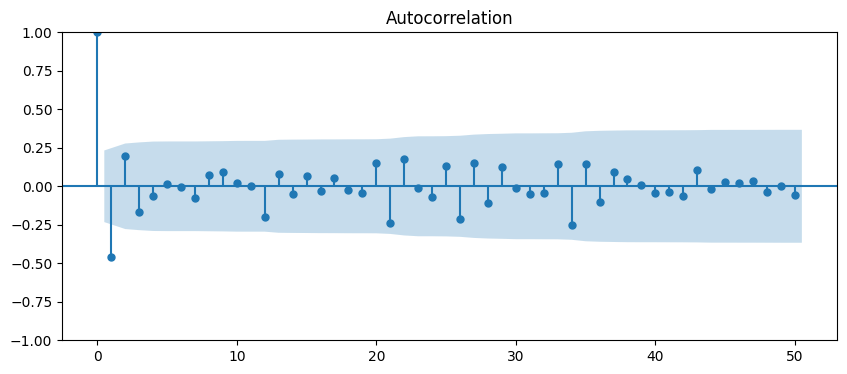

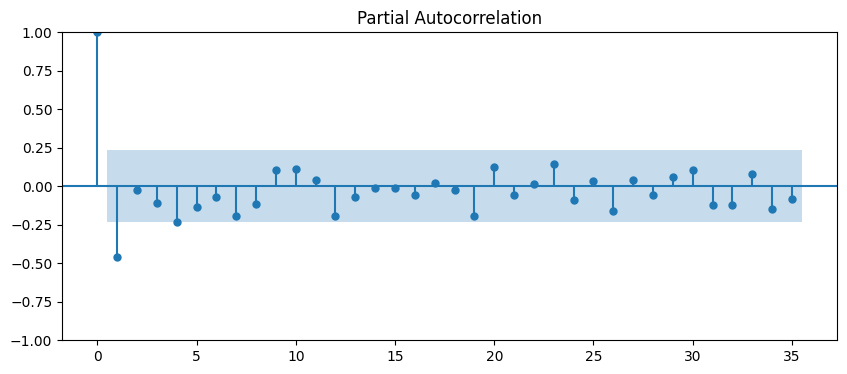

In [13]:
# This function will plot the ACF and PACF. Lag 1 looks significant
# in the ACF, suggesting a MA order near 1. Looking at the "seasonal"
# lags (i.e. looking every 12th lag), there are lags near 24 and 36 that
# are close to significant, suggesting a seasonal order up to 3. The PACF
# has a signficant lag at 1, suggesting an AR order near 1. Maybe there is
# a seasonal lag of 1, it's hard to say

# PACF lags can be up to half the sample size
pacf_lags = np.min([50, int(len(truncated_double_diff) / 2)])
print(f'pacf_lags: {pacf_lags}')

# Calculate ACF and PACF
acf, pacf = sm.tsa.acf(
    truncated_double_diff,
    nlags=50), sm.tsa.pacf(
        truncated_double_diff,
        nlags=pacf_lags)

# Plot ACF
fig, ax = plt.subplots(figsize=(10, 4))
sm.graphics.tsa.plot_acf(truncated_double_diff, lags=50, ax=ax)
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(10, 4))
sm.graphics.tsa.plot_pacf(
    double_diff[13:], lags=pacf_lags, ax=ax)
plt.show()

In [14]:
# auto_arima usually does well, although first you
# need to specify that the frequency is 12 or it won't
# be able to search for the seasonal components
# We'd need to inspect the time series in order to know this

model = pm.auto_arima(
    log_sales,
    seasonal=True,
    m=12,  # Period of the seasonality
    max_p=3,
    max_q=3,
    max_P=2,
    max_Q=2,
    start_P=1, # Start with non-zero seasonal orders
    start_Q=1,
    d=1,  # Non-seasonal difference
    D=1  # Seasonal difference
    )


In [15]:
# Print the selected model architecture
model

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [16]:
# Summarize the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  20.494
Date:                              Sun, 11 Aug 2024   AIC                            -34.988
Time:                                      02:41:47   BIC                            -28.200
Sample:                                  01-01-1995   HQIC                           -32.289
                                       - 12-01-2001                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5017      0.103     -4.860      0.000      -0.704      -0.299
ma.S.L12      -0.5107      0.161     -3.167      0.002      -0.827      -0.195
sigma2         0.0311      0.006      5.017      0.000       0.019       0.043
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.90   Prob(JB):                         1.00
Heteroskedasticity (H):               0.47   Skew:                             0.00
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

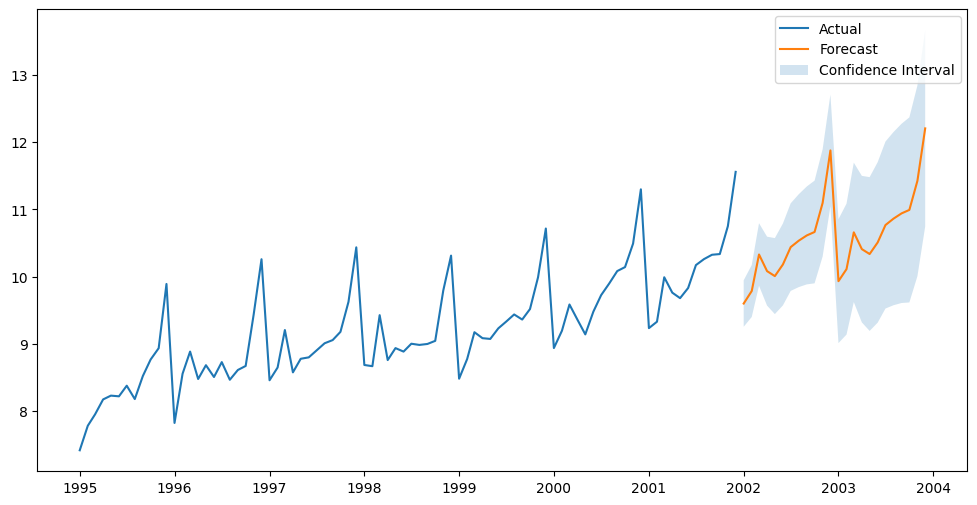

In [17]:
# Generate forecasts
forecast_horizon=24 # 24 months

# Get predictions and confidence intervals
forecast, conf_int = model.predict(
    n_periods=forecast_horizon,
    return_conf_int=True,
    alpha=0.05)

# Create a DataFrame for the forecast
start_date = log_sales.index[-1] + pd.offsets.MonthEnd(1)
forecast_df = pd.DataFrame(
    {'Forecast': forecast.values,
     'Lower CI': conf_int[:, 0],
     'Upper CI': conf_int[:, 1]},
    index=pd.date_range(
        start=start_date,
        periods=forecast_horizon,
        freq='MS')
)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(log_sales, label='Actual')
plt.plot(forecast_df['Forecast'], label='Forecast')
plt.fill_between(
    forecast_df.index,
    forecast_df['Lower CI'],
    forecast_df['Upper CI'],
    alpha=0.2,
    label='Confidence Interval')
plt.legend()
plt.show()

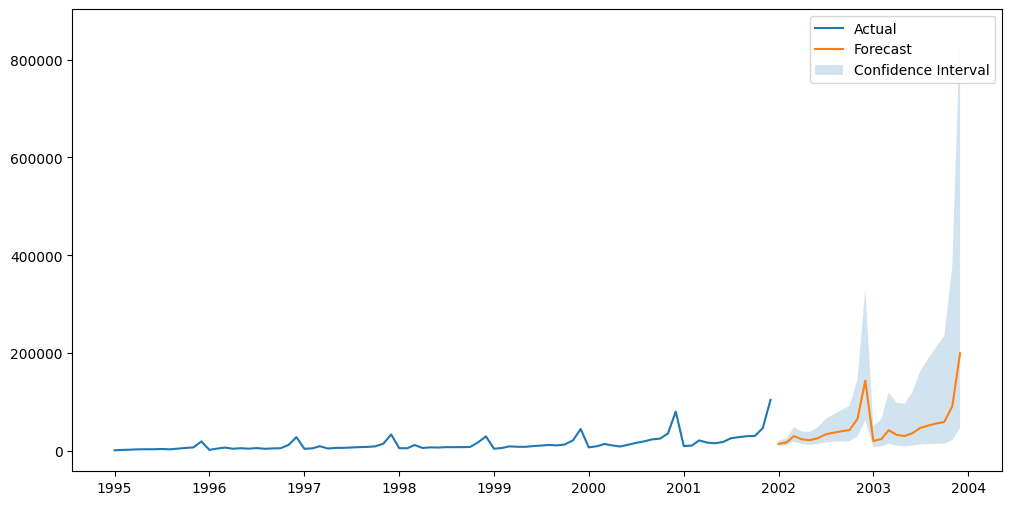

In [18]:
# Back transform to the original scale (invert the log transformation)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(np.exp(log_sales), label='Actual')
plt.plot(np.exp(forecast_df['Forecast']), label='Forecast')
plt.fill_between(
    forecast_df.index,
    np.exp(forecast_df['Lower CI']),
    np.exp(forecast_df['Upper CI']),
    alpha=0.2,
    label='Confidence Interval')
plt.legend()
plt.show()

# Holt-Winters -- Triple Exponential Smoothing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


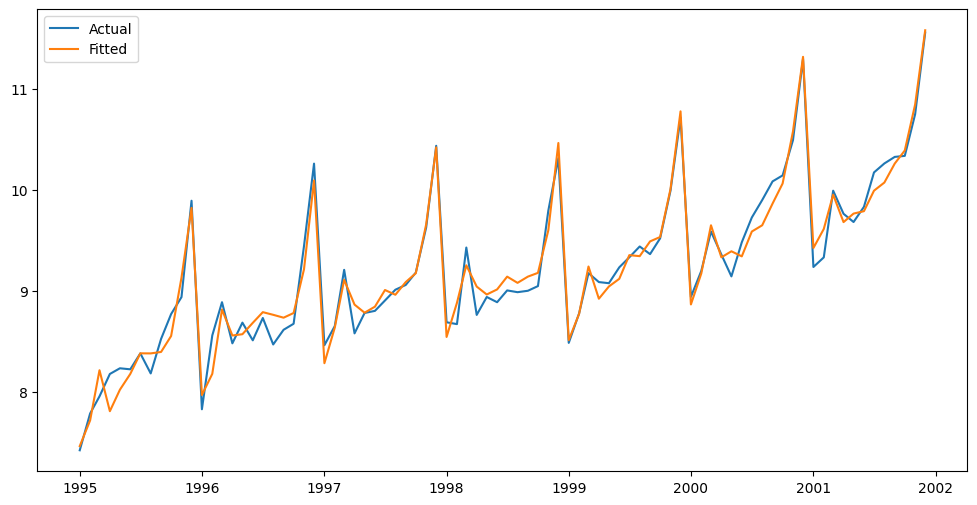

In [19]:
# Fit the triple exponential smoothing model
model = ExponentialSmoothing(
    log_sales,
    trend='additive',
    seasonal='additive',
    seasonal_periods=12).fit()

# Plot the actual data and the fitted model
plt.figure(figsize=(12, 6))
plt.plot(log_sales, label='Actual')
plt.plot(model.fittedvalues, label='Fitted')
plt.legend()
plt.show()

# Generate forecasts
forecast = model.forecast(steps=12)

# TODO: figure out how to get a prediction interval
# conf_int = model.conf_int(steps=12)

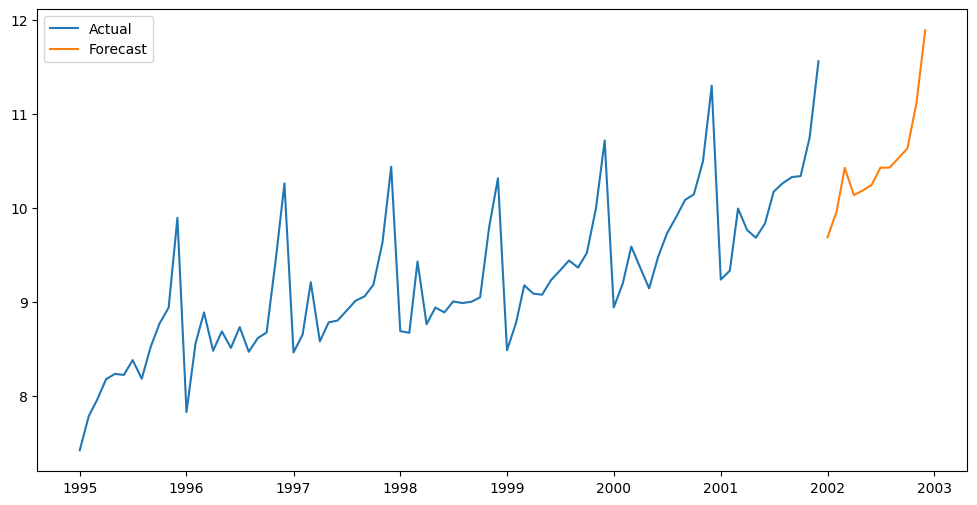

In [20]:
# Plot the forecast on the log scale

plt.figure(figsize=(12, 6))
plt.plot(log_sales, label='Actual')
plt.plot(forecast, label='Forecast')
# plt.fill_between(
#     forecast_df.index,
#     forecast_df['Lower CI'],
#     forecast_df['Upper CI'],
#     alpha=0.2,
#     label='Confidence Interval')
plt.legend()
plt.show()

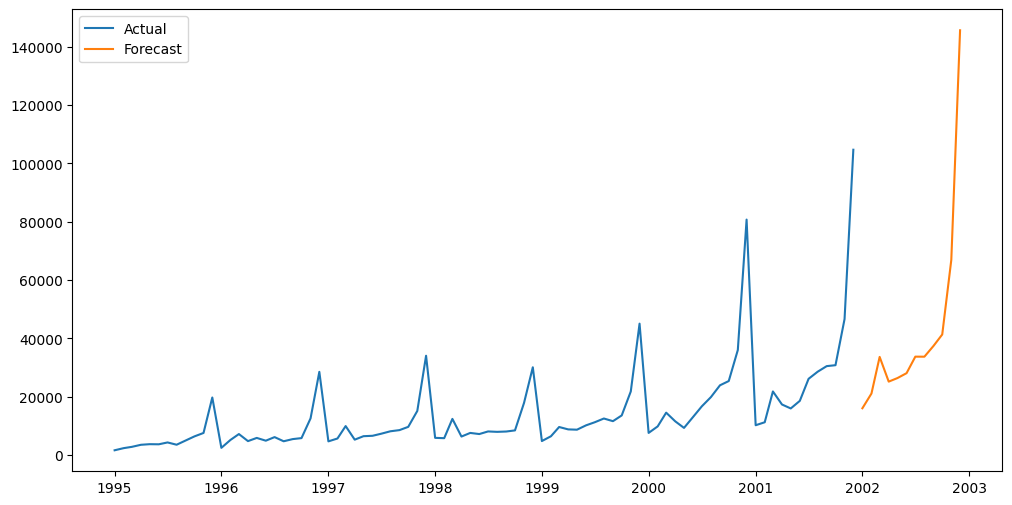

In [21]:
# Plot the forecast on the original scale

plt.figure(figsize=(12, 6))
plt.plot(np.exp(log_sales), label='Actual')
plt.plot(np.exp(forecast), label='Forecast')
# plt.fill_between(
#     forecast_df.index,
#     forecast_df['Lower CI'],
#     forecast_df['Upper CI'],
#     alpha=0.2,
#     label='Confidence Interval')
plt.legend()
plt.show()